In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
# import scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Part 1 - EDA:

In [2]:
os.listdir(path='.')

['.gitignore',
 '.ipynb_checkpoints',
 'Data Science Take-Home Challenge - Ultimate Inc.ipynb',
 'logins.json',
 'ultimate_data_challenge.json',
 'ultimate_data_science_challenge (1).pdf']

In [3]:
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins_df[-5:]

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


**Note:** Data covers 1/1/1970 - 4/13/1970<br>(3 months, 12 days)

In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


**Note:** 'login_time' already in datetime64 format

In [6]:
logins_df.duplicated().sum() # number of duplicates we need to drop

877

In [7]:
logins_df[logins_df.duplicated(keep=False)].head(10)
# duplicates listed together (first 2 duplicate pairs are 7 logins apart and the following 3 are 3 logins apart)
# May be intentionally-generated duplicates

,login_time
347,1970-01-02 10:59:52
354,1970-01-02 10:59:52
427,1970-01-02 12:27:48
434,1970-01-02 12:27:48
503,1970-01-02 15:08:27
506,1970-01-02 15:08:27
521,1970-01-02 16:14:36
524,1970-01-02 16:14:36
669,1970-01-02 22:03:36
672,1970-01-02 22:11:16


In [8]:
df_clean = logins_df.drop_duplicates() # keeping first occurence by default (keep='first')
df_clean = df_clean.sort_values(by='login_time') # to be sure
df_clean.count()

login_time    92265
dtype: int64

In [9]:
df_clean.loc[:,'count'] = 1
df_clean.head()

,login_time,count
6,1970-01-01 20:12:16,1
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
3,1970-01-01 20:16:36,1
2,1970-01-01 20:16:37,1


**Note:** login_time column was originally out of order

In [10]:
df_grouped = df_clean.groupby(pd.Grouper(key="login_time", freq="15min")).sum()
print('grouped count:',len(df_grouped),
      '\nungrouped count:', len(df_clean),
      '\nAverage login count per 15min:',len(df_clean)/len(df_grouped))
df_grouped.head()

grouped count: 9788 
ungrouped count: 92265 
Average login count per 15min: 9.426338373518595


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [11]:
df_grouped.loc[:,'number_weekday'] = df_grouped.index.weekday
df_grouped.loc[:,'weekday'] = df_grouped.index.day_name()
df_grouped.loc[:,'month'] = df_grouped.index.month_name()
df_grouped[970:980]

,count,number_weekday,weekday,month
login_time,,,,
1970-01-11 22:30:00,4,6,Sunday,January
1970-01-11 22:45:00,6,6,Sunday,January
1970-01-11 23:00:00,2,6,Sunday,January
1970-01-11 23:15:00,6,6,Sunday,January
1970-01-11 23:30:00,8,6,Sunday,January
1970-01-11 23:45:00,5,6,Sunday,January
1970-01-12 00:00:00,4,0,Monday,January
1970-01-12 00:15:00,10,0,Monday,January
1970-01-12 00:30:00,7,0,Monday,January


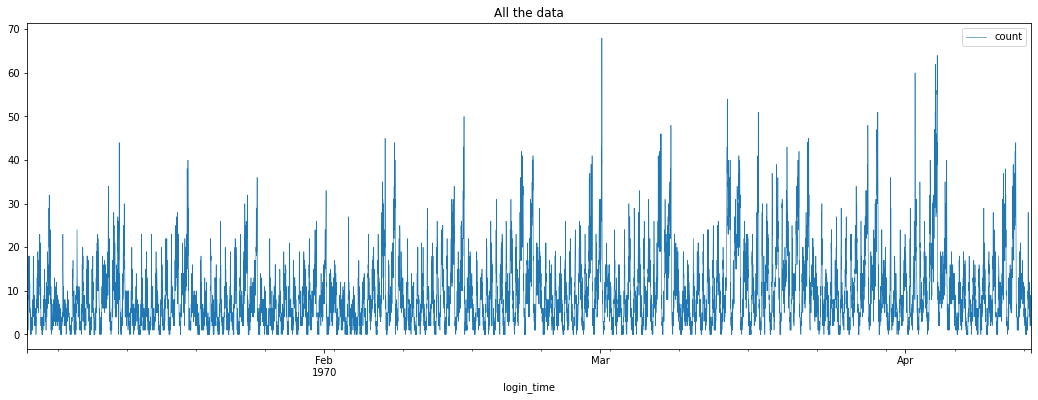

In [12]:
df_grouped.plot(y='count', figsize=(18,6), linewidth=0.6, title='All the data');

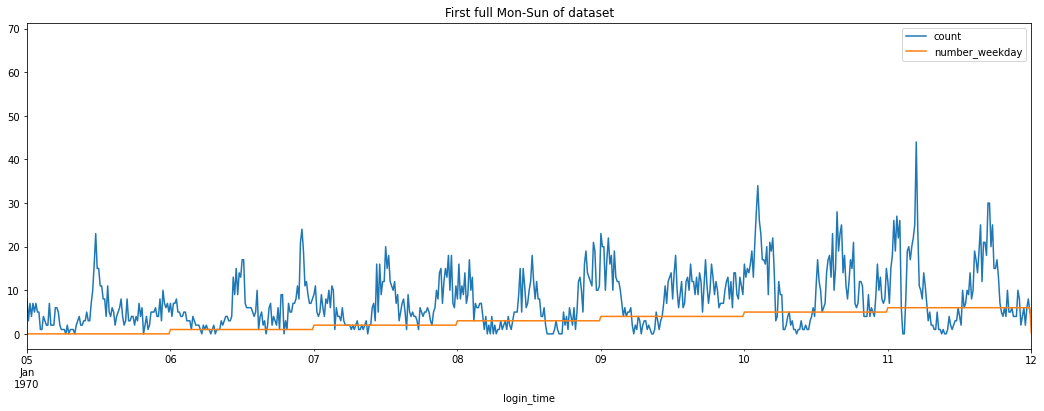

In [13]:
df_grouped.plot(figsize=(18,6), xlim=('1970-01-05 00:00:00','1970-01-12 00:00:00'), title='First full Mon-Sun of dataset');

In [14]:
df_grouped.loc['1970-01-02 00:00:00','weekday']

'Friday'

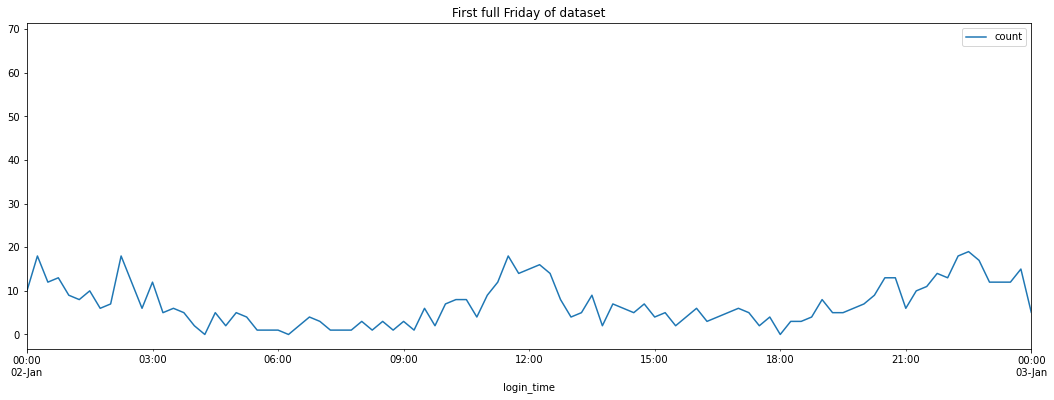

In [15]:
df_grouped.plot(y='count', figsize=(18,6), xlim=('1970-01-02 00:00:00','1970-01-03 00:00:00'),\
                title='First full Friday of dataset');

# Part 2 - Experiment and Metrics Design:

# Part 3 - Predictive Modeling: